In [112]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import matplotlib.patches as mpatches

## Q-Learning:


\begin{equation*}SuttonBarto : Q(S_t,A_t)\longleftarrow Q(S_t,A_t) + \alpha[R_{t+1}+\gamma max_{a}Q(s_{t+1},a)-Q(S_t,A_t)]
\end{equation*}





In [113]:
N_ROWS = 1
N_COLS = 5
GRID_WORLD = np.zeros((N_ROWS, N_COLS))

GRID_WORLD[(0,4)] = 10
GRID_WORLD[(0,0)] = -10


ACTIONS = ('Left', 'Right')

GAMMA = .8
ALPHA = 0.2
MIN_EPSILON = 0.03

In [114]:
class Agent():
    
    def __init__(self, initial_state, world_knowledge):
        self.initial_state = initial_state
        self.current_state = initial_state
        self.knowledge = {(i,j): {} for i in range(N_ROWS) for j in range(N_COLS)}
        self.world_knowledge = world_knowledge
                
        
    def __str__(self) -> str:
        return f'turti at {self.current_state} with knowledge {self.knowledge[self.current_state]}'
    
    
    def change_world_knowledge(self, state, value):
        self.world_knowledge[state] = value
    
    
    def get_next_state(self, base_state, next_action:str)->tuple:
        if next_action == 'Up':
            new_state = (max(base_state[0]-1, 0), base_state[1])
        elif next_action == 'Down':
            new_state = (min(base_state[0]+1, N_ROWS-1), base_state[1])
        elif next_action == 'Left':
            new_state = (base_state[0], max(base_state[1]-1, 0))
        elif next_action == 'Right':
            new_state = (base_state[0], min(base_state[1]+1, N_COLS-1))
        return new_state
    
    
    def get_best_action(self, state):
        
        possible_actions = [a for a in ACTIONS if self.get_next_state(state, a) != state]
        random.shuffle(possible_actions)
        
        # 0? or the value in grid world?
        
        actions = sorted([(a, self.knowledge[state].get(a, 0)) 
                          for a in possible_actions], 
                         key=lambda x: x[1], reverse=True)
        
        # actions[0] if actions else (None, 0)
        
        return actions[0]

    
    
    def calculate_next_action_reward(self, next_state, action):
        
        if next_state==self.current_state:
            return self.knowledge[self.current_state].get(action, 0)
        
        # Current value of the state with the action
        q_a_st = self.knowledge[self.current_state].get(action, 0)
        
        # Max value possible value in the next state # corroborar
        q_max_a_st1 = self.knowledge[next_state].get(self.get_best_action(next_state)[0], 0)
        
        
        q = q_a_st + ALPHA * (self.world_knowledge[next_state] + GAMMA * q_max_a_st1 - q_a_st) 
        
        return q
    
    
    def update_q_knowledge(self):
        for action in ACTIONS:
            next_state = self.get_next_state(self.current_state, action)
            if next_state == self.current_state:
                continue
            self.knowledge[self.current_state][action] = self.calculate_next_action_reward(next_state, action)

    
    def choose_greedy_action(self, epsilon):
        
        if random.random() < epsilon:
            return random.choice(ACTIONS)
        else:
            # best_action, _ = self.get_best_action(self.current_state)
            return self.get_best_action(self.current_state)[0]
    

    def restart(self):
        self.current_state = self.initial_state
        
        
    def epsilon_decay(self, t, decay_rate=0.06):
        return MIN_EPSILON + (1-MIN_EPSILON) * np.exp(-decay_rate*t)
        
            
    def move(self, t):
        
        self.update_q_knowledge()
        
        new_action = self.choose_greedy_action(epsilon=self.epsilon_decay(t))
        
        new_state = self.get_next_state(self.current_state, new_action)
        
        self.current_state = new_state
                
        if (new_state == (0,4)) or (new_state == (0,0)):
            self.restart()
            return self.initial_state
            
        
        return new_state

In [115]:
win_state = (0,4)
lose_state = (0,0)

### Grid World with Dynamic Reward Function for Continuous Learning

We define a grid world consisting of a single row and five columns. The first cell on the left endows the agent with the lowest reward (-10), representing a penalizing state, whereas the cell on the far right constitutes the 'win' state, offering a high reward of +10. The agent commences each episode at the center of the grid, which serves as the initial state. Upon reaching either extreme of the grid, the agent's state resets to this central starting point.

The primary objective is to explore the dynamics of the Q-learning algorithm, employing a decaying $\epsilon$-greedy strategy to manage the exploration-exploitation trade-off, particularly when the rewards are subject to variation over time. We aim to introduce modifications to the algorithm, enabling the agent to adapt its approach to exploration and exploitation as the environment evolves.

In [119]:
turti = Agent(initial_state=(0,2), world_knowledge=GRID_WORLD.copy())

time = [t for t in range(150)]
moves = []
rewards = []

for t in time:
    
    pos_i = turti.current_state
    turti.move(t=t)
    pos_f = turti.current_state
    
    if (pos_f == (0,2)) and (pos_i == (0,3)):
        action = 'Right'
        
    elif (pos_f == (0,2)) and (pos_i == (0,1)):
        action = 'Left'
    else:
        action = 'Right' if pos_f[1]-pos_i[1]>0 else 'Left'
    
    reward_obtained = turti.knowledge[pos_i][action]
    
    moves.append(action)
    rewards.append(reward_obtained)

The accompanying visual represents the initial setup and the resulting Q-values of our grid world after 200 training iterations. As illustrated in the chart, the Q-values adjacent to each cell reflect the learned policy of the agent. Through iterative learning, the agent has successfully discerned the optimal path to the highest reward. The Q-values indicate a clear gradient of increasing utility as the agent progresses from left to right, aligning with the objective of reaching the positive terminal state. Specifically, the agent has learned to assign higher values to actions directing it toward the 'win' state, as seen by the predominance of higher Q-values on the rightward actions in cells closer to the reward. The Q-values convergence, particularly adjacent to the terminal states, demonstrates a satisfactory understanding by the agent of the task at hand.

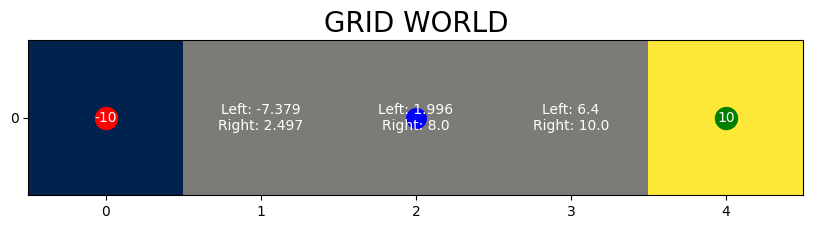

In [120]:
plt.figure(figsize=(10,5))
plt.imshow(GRID_WORLD, cmap='cividis', norm='linear')

for i in range(GRID_WORLD.shape[0]):
        for j in range(GRID_WORLD.shape[1]):
            if (j,i)!=(4,0) and (j,i)!=(0,0):
                actions = turti.knowledge[(i,j)]
                actions = '\n'.join([f'{a}: {round(v, 3)}' for a, v in actions.items()])
                plt.text(j, i, f'{actions}', ha='center', va='center', color='white') 

plt.text(0, 0, f'{-10}', ha='center', va='center', color='white')
plt.text(4, 0, f'{10}', ha='center', va='center', color='white')
            
plt.scatter(turti.initial_state[1], turti.initial_state[0], color='b', s=200)
plt.title('GRID WORLD', fontsize=20)    

plt.scatter(4, 0, color='g', s=250)
plt.scatter(0, 0, color='r', s=250)

plt.yticks(np.arange(0, N_ROWS, 1), )

plt.show()

The graph presented herein provides a dynamic visualization of the agent's exploration behavior and subsequent policy learning within the grid world environment. Initially, the agent engages in a phase of exploration, alternating between leftward and rightward movements, thereby encountering both positive and negative rewards. This exploratory phase is characterized by fluctuations in the reward signal, as depicted by the oscillating blue (left) and orange (right) markers.

Around the 25th iteration, a discernible shift in strategy emerges. The agent, through trial and error, identifies a pattern: moving rightward consistently yields a higher reward. This realization precipitates a strategic pivot from exploration to exploitation, where the agent increasingly favors rightward movements. The graph exhibits this transition with a steady climb of orange markers, indicating a preference for the action that accrues the highest reward.

Post the initial exploratory period, the agent's trajectory stabilizes, showcasing a clear understanding and exploitation of the reward structure. By maximizing the returns through a right-biased policy, the agent demonstrates effective learning. The periodic dips in reward on the left actions, which become less frequent over time, indicate sporadic revisits to the exploration phase, ensuring that the agent remains responsive to potential changes in the environment.

By the conclusion of 200 iterations, the graph delineates a strong inclination towards the action that leads to the win state, underscored by a dense clustering of orange markers at the higher reward end of the spectrum. This pattern evidences the agent's successful adaptation and optimization of its policy, culminating in a proficient strategy that reliably steers towards the highest reward.

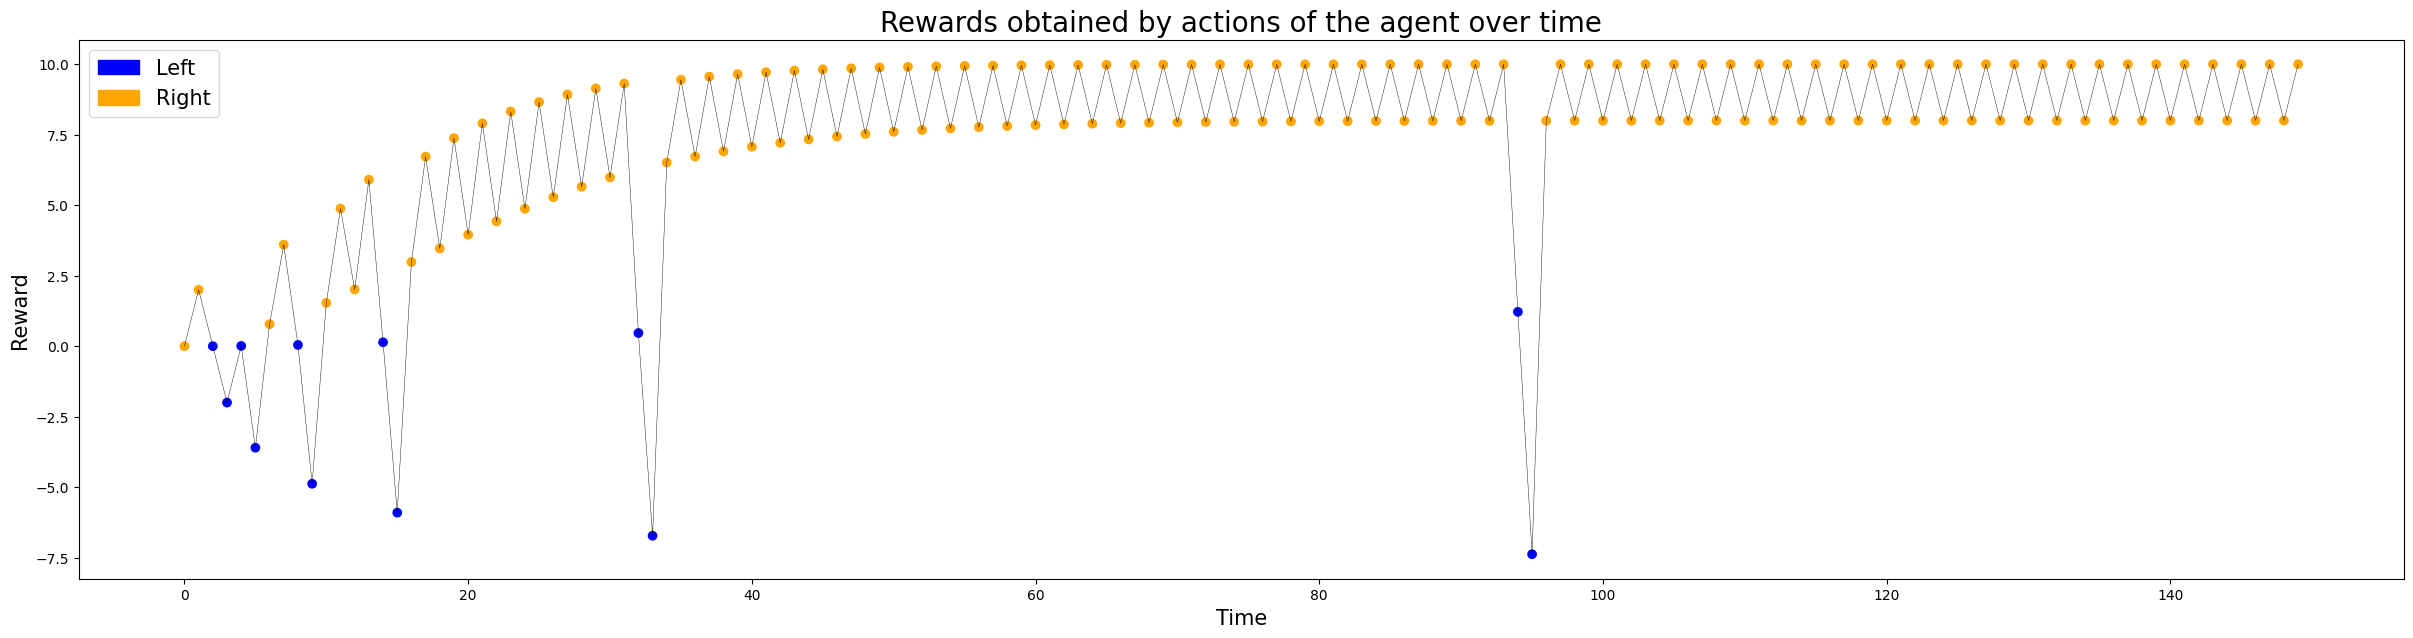

In [121]:
plt.figure(figsize=(30,7))
plt.scatter(time, rewards, color = ['blue' if m=='Left' else 'orange' for m in moves])
plt.plot(time, rewards, linewidth=0.3, color='k')
# Crear parches para la leyenda
blue_patch = mpatches.Patch(color='blue', label='Left',)
orange_patch = mpatches.Patch(color='orange', label='Right')

# Mostrar la leyenda
plt.legend(handles=[blue_patch, orange_patch], loc='upper left', fontsize=15)
plt.ylabel('Reward', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.title('Rewards obtained by actions of the agent over time', fontsize=20)
plt.show();

## Adaptive Response of an Agent to Changing Reward Structures

The last graph demonstrates a significant phase in the agent's learning trajectory, wherein by the 100th iteration, the agent appears to have nearly converged to an optimal policy under the original reward configuration. The subsequent plot introduces a pivotal test: the rewards are inverted, challenging the agent to adapt to this new reward landscape.

As depicted, following the inversion, the agent persists in moving right for a considerable duration, a behavior anchored in the previously learned policy that associated rightward movement with higher rewards. Notably, the unlearning process is prolonged, underscoring the agent's inherent "greedy" strategy that compels it to exploit known rewarding actions even when they become suboptimal.

The plot vividly illustrates that despite the agent's commitment to a previously successful action, it gradually begins to recognize the diminished utility of moving right and slowly shifts its policy. This adjustment, however, requires significant time, as the newly assigned lower rewards for rightward actions must outweigh the previously learned values.

This experiment accentuates the need for implementing a cognitive signal within the agent's decision-making framework. Such a mechanism would trigger a shift from exploitation back to exploration, prompting the agent to reassess and rediscover optimal actions under the revised reward conditions. Instilling this cognitive flexibility would enable the agent to more swiftly recalibrate its strategy in response to changes, mitigating the inertia of its prior knowledge.

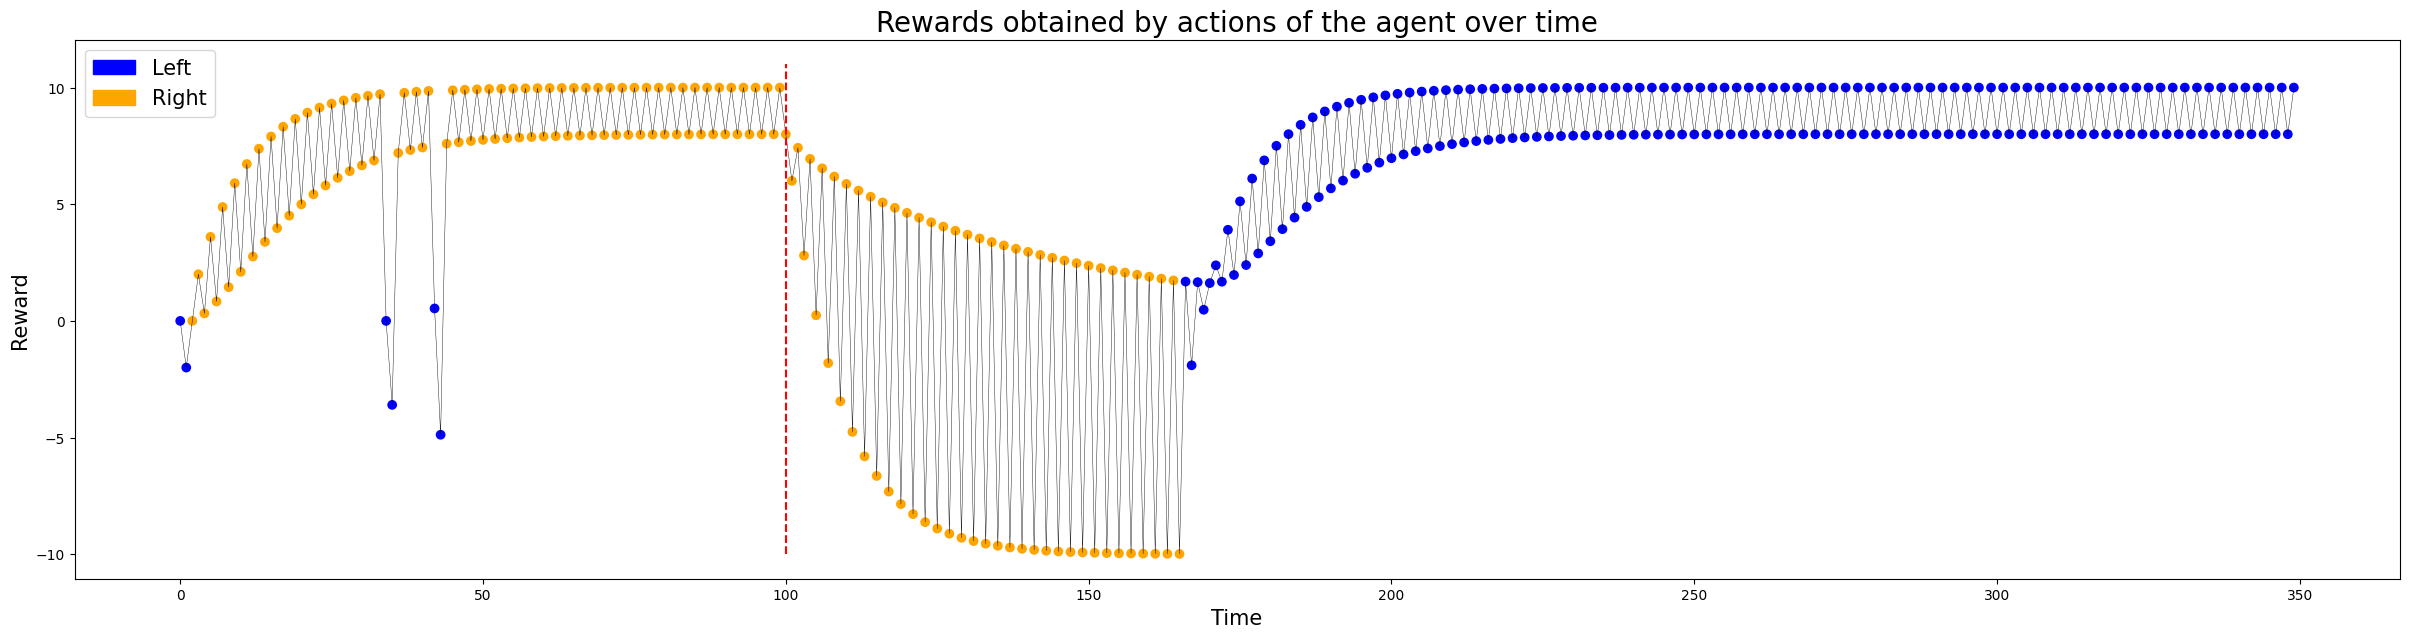

In [123]:
turti = Agent(initial_state=(0,2), world_knowledge=GRID_WORLD.copy())

time = [t for t in range(350)]
moves = []
rewards = []

for t in time:
    
    if t == 100:
        turti.change_world_knowledge((0,4), -10)
        turti.change_world_knowledge((0,0), 10)
    
    pos_i = turti.current_state
    turti.move(t=t)
    pos_f = turti.current_state
    
    if (pos_f == (0,2)) and (pos_i == (0,3)):
        action = 'Right'
    elif (pos_f == (0,2)) and (pos_i == (0,1)):
        action = 'Left'
    else:
        action = 'Right' if pos_f[1]-pos_i[1]>0 else 'Left'
    
    reward_obtained = turti.knowledge[pos_i][action]
    
    moves.append(action)
    rewards.append(reward_obtained)
    
    

plt.figure(figsize=(30,7))
plt.scatter(time, rewards, color = ['blue' if m=='Left' else 'orange' for m in moves])
plt.plot(time, rewards, linewidth=0.3, color='k')
plt.vlines(x=100, ymin=-10, ymax=11, color='r', linestyle='--')
# Crear parches para la leyenda
blue_patch = mpatches.Patch(color='blue', label='Left',)
orange_patch = mpatches.Patch(color='orange', label='Right')

# Mostrar la leyenda
plt.legend(handles=[blue_patch, orange_patch], loc='upper left', fontsize=15)
plt.ylabel('Reward', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.title('Rewards obtained by actions of the agent over time', fontsize=20)
plt.show();

In [124]:
moves[95:105]

['Right',
 'Right',
 'Right',
 'Right',
 'Right',
 'Right',
 'Right',
 'Right',
 'Right',
 'Right']

In [148]:
last_rewards = [7.997517927059403,7.996967098652999,7.997969740157125]
avg_r = np.mean(last_rewards)
std_r = np.std(last_rewards)
avg_r, 3*std_r

(7.997484921956509, 0.0012299743876888832)

In [147]:
abs(avg_r-7.420986634819418) > 3*std_r

True

In [127]:
rewards[95:105]

[9.99956443857034,
 7.99695873587355,
 9.999651550856273,
 7.997511236835844,
 9.999721240685018,
 7.997964387978278,
 5.999776992548014,
 7.421008249058476,
 2.799821594038411,
 6.94489380136336]

## Dynamic "Q-Learning"

In [144]:
class Agent_cl():
    
    def __init__(self, initial_state, world_knowledge):
        self.step = 0
        self.initial_state = initial_state
        self.current_state = initial_state
        self.knowledge = {(i,j): {'short_memory':[]} for i in range(N_ROWS) for j in range(N_COLS)}
        self.world_knowledge = world_knowledge
                
        
    def __str__(self) -> str:
        return f'turti at {self.current_state} with knowledge {self.knowledge[self.current_state]}'
    
    
    def change_world_knowledge(self, state, value):
        self.world_knowledge[state] = value
    
    
    def get_next_state(self, base_state, next_action:str)->tuple:
        if next_action == 'Up':
            new_state = (max(base_state[0]-1, 0), base_state[1])
        elif next_action == 'Down':
            new_state = (min(base_state[0]+1, N_ROWS-1), base_state[1])
        elif next_action == 'Left':
            new_state = (base_state[0], max(base_state[1]-1, 0))
        elif next_action == 'Right':
            new_state = (base_state[0], min(base_state[1]+1, N_COLS-1))
        return new_state
    
    
    def get_best_action(self, state):
        
        possible_actions = [a for a in ACTIONS if self.get_next_state(state, a) != state]
        random.shuffle(possible_actions)
        
        # 0? or the value in grid world?
        
        actions = sorted([(a, self.knowledge[state].get(a, 0)) 
                          for a in possible_actions], 
                         key=lambda x: x[1], reverse=True)
        
        # actions[0] if actions else (None, 0)
        
        return actions[0]

    
    
    def calculate_next_action_reward(self, next_state, action):
        
        if next_state==self.current_state:
            return self.knowledge[self.current_state].get(action, 0)
        
        # Current value of the state with the action
        q_a_st = self.knowledge[self.current_state].get(action, 0)
        
        # Max value possible value in the next state # corroborar
        q_max_a_st1 = self.knowledge[next_state].get(self.get_best_action(next_state)[0], 0)
        
        
        q = q_a_st + ALPHA * (self.world_knowledge[next_state] + GAMMA * q_max_a_st1 - q_a_st) 
        
        return q
    
    
    def update_q_knowledge(self):
        for action in ACTIONS:
            next_state = self.get_next_state(self.current_state, action)
            if next_state == self.current_state:
                continue
            self.knowledge[self.current_state][action] = self.calculate_next_action_reward(next_state, action)

    
    def choose_greedy_action(self, epsilon):
        
        if random.random() < epsilon:
            return random.choice(ACTIONS)
        else:
            best_action, max_reward = self.get_best_action(self.current_state)
            self.knowledge[self.current_state]['short_memory'].append(max_reward)
            
            return best_action
    

    def restart(self):
        self.current_state = self.initial_state
        
        
    def epsilon_decay(self, t, decay_rate=0.06):
        return MIN_EPSILON + (1-MIN_EPSILON) * np.exp(-decay_rate*t)
        
            
    def move(self):
        
        #if t == 0:
        #    self.knowledge = {(i,j): {'short_memory':[]} for i in range(N_ROWS) for j in range(N_COLS)}
        
        self.update_q_knowledge()
        
        new_action = self.choose_greedy_action(epsilon=self.epsilon_decay(self.step))
        
        self.step += 1
        
        new_state = self.get_next_state(self.current_state, new_action)
        
        self.current_state = new_state
                
        if (new_state == (0,4)) or (new_state == (0,0)):
            self.restart()
            return self.initial_state
            
        
        return new_state

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


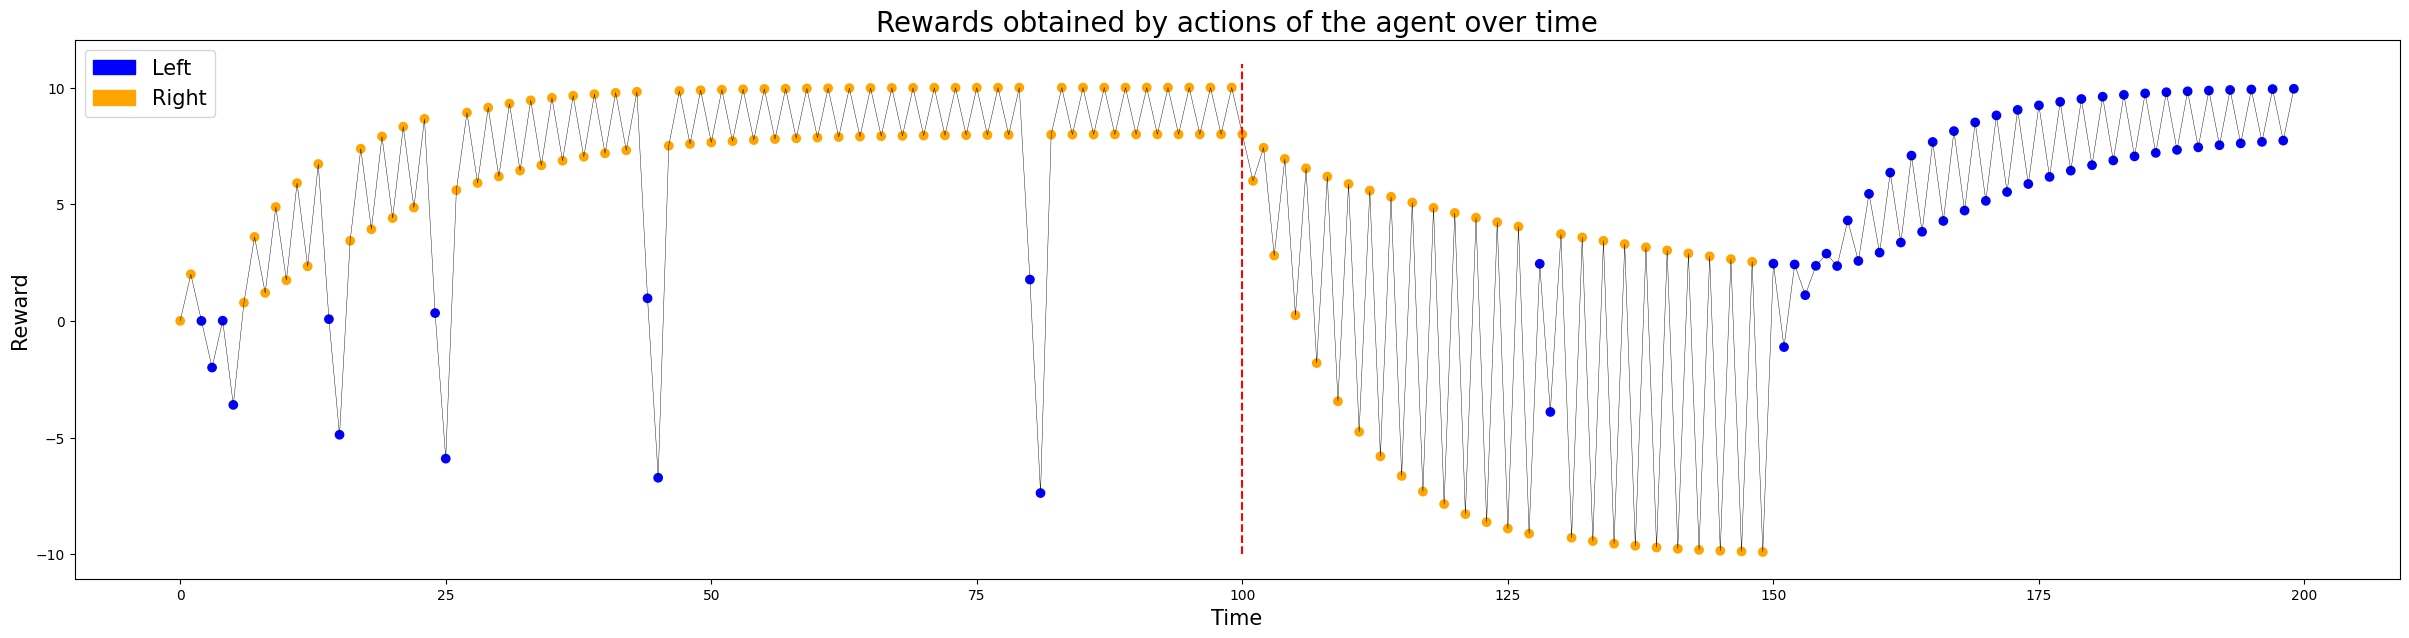

In [145]:
turti = Agent_cl(initial_state=(0,2), world_knowledge=GRID_WORLD.copy())

time = [t for t in range(200)]
moves = []
rewards = []

change_time = 100
for t in time:
    
    if t == change_time:
        turti.change_world_knowledge((0,4), -10)
        turti.change_world_knowledge((0,0), 10)
    
    pos_i = turti.current_state
    turti.move()
    pos_f = turti.current_state
    
    if (pos_f == (0,2)) and (pos_i == (0,3)):
        action = 'Right'
    elif (pos_f == (0,2)) and (pos_i == (0,1)):
        action = 'Left'
    else:
        action = 'Right' if pos_f[1]-pos_i[1]>0 else 'Left'
    
    reward_obtained = turti.knowledge[pos_i][action]
    
    moves.append(action)
    rewards.append(reward_obtained)
    
    

plt.figure(figsize=(30,7))
plt.scatter(time, rewards, color = ['blue' if m=='Left' else 'orange' for m in moves])
plt.plot(time, rewards, linewidth=0.3, color='k')
plt.vlines(x=100, ymin=-10, ymax=11, color='r', linestyle='--')
# Crear parches para la leyenda
blue_patch = mpatches.Patch(color='blue', label='Left',)
orange_patch = mpatches.Patch(color='orange', label='Right')

# Mostrar la leyenda
plt.legend(handles=[blue_patch, orange_patch], loc='upper left', fontsize=15)
plt.ylabel('Reward', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.title('Rewards obtained by actions of the agent over time', fontsize=20)
plt.show();

In [146]:
turti.knowledge

{(0, 0): {'short_memory': []},
 (0,
  1): {'short_memory': [0.051200000000000016,
   0.13312000000000004,
   1.305486356905984,
   2.2313732232075143,
   3.0615537268854522,
   3.067424454894265,
   2.846461284288597,
   2.664055812607214,
   2.881741824,
   4.3053934592,
   5.44431476736,
   6.355451813888,
   7.0843614511104,
   7.66748916088832,
   8.133991328710657,
   8.507193062968526,
   8.80575445037482,
   9.044603560299857,
   9.235682848239886,
   9.388546278591908,
   9.510837022873528,
   9.608669618298823,
   9.686935694639057,
   9.749548555711247,
   9.799638844568998,
   9.839711075655199,
   9.87176886052416,
   9.897415088419327,
   9.917932070735462,
   9.93434565658837,
   9.947476525270696], 'Left': 9.947476525270696, 'Right': 5.79958902353747},
 (0,
  2): {'short_memory': [0.7808,
   1.2006400000000002,
   2.3376896000000005,
   3.4324029440000006,
   3.9264919552000004,
   4.40564924416,
   4.856083939328,
   5.60134666452992,
   5.9092786397839365,
   6.1899839

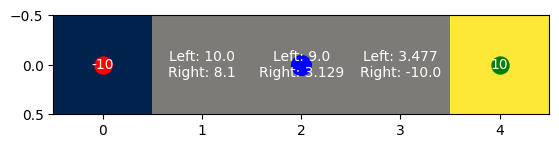

In [60]:
plt.imshow(GRID_WORLD, cmap='cividis', norm='linear')

for i in range(GRID_WORLD.shape[0]):
        for j in range(GRID_WORLD.shape[1]):
            if (j,i)!=(4,0) and (j,i)!=(0,0):
                actions = turti.knowledge[(i,j)]
                actions = '\n'.join([f'{a}: {round(v, 3)}' for a, v in actions.items()])
                plt.text(j, i, f'{actions}', ha='center', va='center', color='white') 

plt.text(0, 0, f'{-10}', ha='center', va='center', color='white')
plt.text(4, 0, f'{10}', ha='center', va='center', color='white')
            
plt.scatter(turti.initial_state[1], turti.initial_state[0], color='b', s=200)

plt.scatter(4, 0, color='g', s=150)
plt.scatter(0, 0, color='r', s=150)

plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


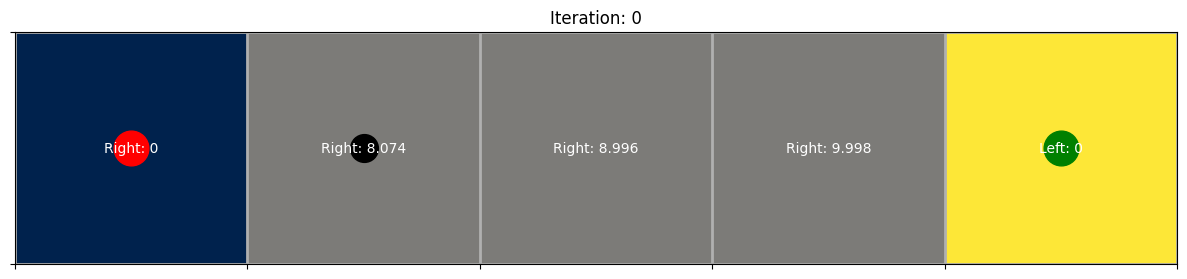

In [84]:
turti = Agent(initial_state=(0,2), world_knowledge=GRID_WORLD.copy())

fig, ax = plt.subplots(figsize=(15, 8))

def update(ite):
    world_knowledge = GRID_WORLD.copy()
    ax.clear()
    ax.set_title(f'Iteration: {ite}')
    ax.imshow(world_knowledge, cmap='cividis')
    
    ax.set_xticks(np.arange(-.5, N_COLS, 1))
    ax.set_yticks(np.arange(-.5, N_ROWS, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.grid(which='both', linewidth=2)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    
    for i in range(world_knowledge.shape[0]):
        for j in range(world_knowledge.shape[1]):
            best_action, value = turti.get_best_action((i,j))
            ax.text(j, i, f'{best_action}: {round(value, 3)}', ha='center', va='center', color='white')        
        
    ax.plot(turti.current_state[1], turti.current_state[0], 'ko', markersize=20)
    
    ax.plot(win_state[1], win_state[0], 'go', markersize=25)
    ax.plot(lose_state[1], lose_state[0], 'ro', markersize=25)
    if ite>0:
        turti.move(t=i)
    return ax

ani = animation.FuncAnimation(fig, update, frames=range(300))
ani.save('simulations/q_learning_clv1.gif', fps=10)

In [6]:
'''
for _ in range(200):
    next_action = turti.choose_action()
    turti.move(next_action)
    
'''

'\nfor _ in range(200):\n    next_action = turti.choose_action()\n    turti.move(next_action)\n    \n'